# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: <br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя. <br>

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. <br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np   
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
sns.set(style="whitegrid")

## Исследовательский анализ данных

Посмотрим на размер выборки:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В выборке 7591 фотография.

Построим график.

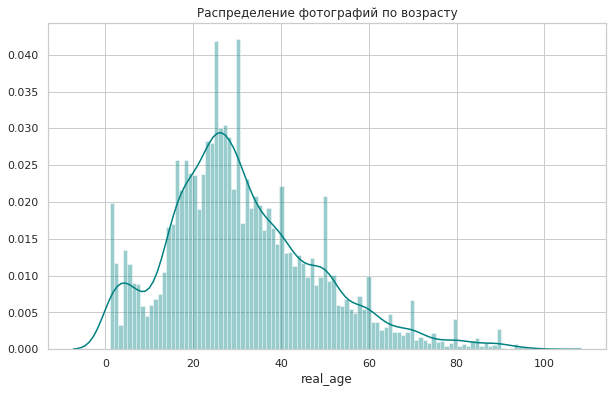

In [5]:
plt.figure(figsize=(10,6))
plt.title('Распределение фотографий по возрасту')
sns.distplot(labels['real_age'], color="Teal", kde=True, bins=100)

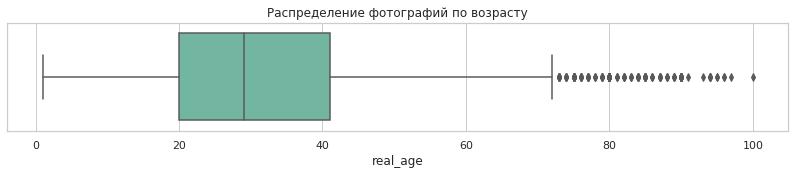

In [6]:
plt.figure(figsize=(14,2))
plt.title('Распределение фотографий по возрасту')
sns.boxplot(data=labels, x='real_age', palette="Set2")

Целевой признак распределен неравномерно, большинство фотографий находятся в промежутке между двадцатью и сорока годами. 

<div class="alert alert-block alert-success">
<b>Успех:</b> Графики получились отлично.
</div>

Загрузим данные.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features,target=next(train_gen_flow)

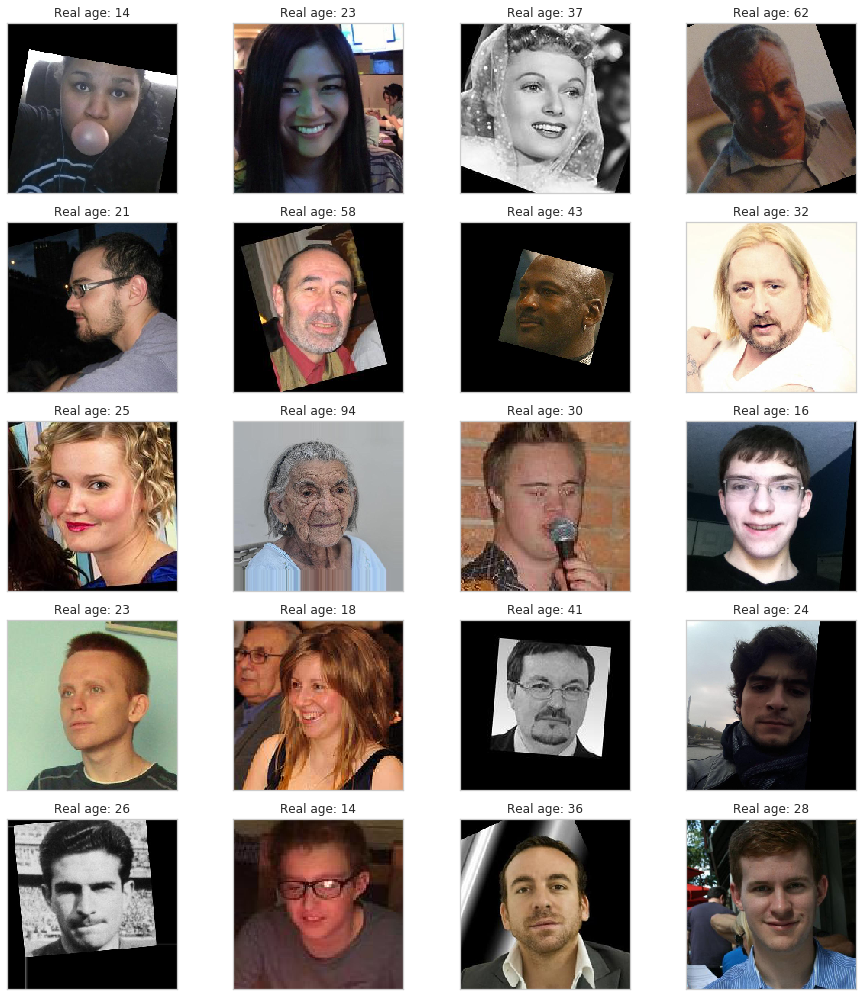

In [9]:
fig = plt.figure(figsize=(14,14))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.title('Real age: ' + str(target[i+10]))
    plt.imshow(features[i+10])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод: Модель будет точнее предсказывать возраст людей в диапазоне 25-30 лет и хуже предсказывать возраст детей и людей старше шестидесяти лет. <br>
Картинки нормального качества, не перевернуты, но есть разброс по освещенности и присутствуют черно-белые фотографии.


## Обучение модели

Обучим нейронную сеть и рассчитаем её качество. <br>

Для построения нейросети будем использовать архитектуру ResNet50 на семь эпох и алгоритм Adam со скоростью обучения 0.0001.  <br>
Функцией потерь поставим MSE. <br>
Метрика качества - MAE. <br>
В обучении используем аугментацию - горизонтальное отражение. 

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,        
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

 
def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps is None:
        validation_steps = len(test_gen_flow)

    model.fit(train_gen_flow,
              validation_data=test_gen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Вывод результата:

<font color='RoyalBlue'>Found 5694 validated image filenames. <br>
Found 1897 validated image filenames. <br>

Train for 356 steps, validate for 119 steps <br>
Epoch 1/7 <br>


356/356 - 113s - loss: 205.4053 - mae: 10.4086 - val_loss: 596.0571 - val_mae: 19.2778 <br>
Epoch 2/7 <br>
356/356 - 38s - loss: 81.1043 - mae: 6.8665 - val_loss: 186.3092 - val_mae: 10.1823 <br>
Epoch 3/7 <br>
356/356 - 38s - loss: 57.0642 - mae: 5.7594 - val_loss: 87.7194 - val_mae: 6.9960 <br>
Epoch 4/7 <br>
356/356 - 38s - loss: 42.3863 - mae: 4.9756 - val_loss: 76.8077 - val_mae: 6.5923 <br>
Epoch 5/7 <br>
356/356 - 38s - loss: 29.9634 - mae: 4.1651 - val_loss: 101.9297 - val_mae: 7.7252 <br>
Epoch 6/7 <br>
356/356 - 38s - loss: 25.2003 - mae: 3.8276 - val_loss: 66.0549 - val_mae: 6.0793 <br>
Epoch 7/7 <br>
356/356 - 37s - loss: 20.2063 - mae: 3.3906 - val_loss: 72.0119 - val_mae: 6.3415</font>

## Анализ обученной модели

Мы проанализировали данные из семи тысяч фотографий покупателей и обучили нейронную сеть их обработке и определению возраста.<br>
Для построения сети мы использовали архитектуру ResNet50 и алгоритм Adam. <br>
Большинство фотографий из предложенного датасета составили фотографии людей возраста 25-30 лет, данных по подросткам и людям старше сорока - значительно меньше. Качество предсказания в этих категориях будет хуже. Чтобы увеличить датасет и избежать переобучения, мы применили к картинкам горизонтальное отражение. <br>
Нашей целью было получить MAE меньше 7, в итоге на шестой эпохе МАЕ на валидационной выборке достигло 6.0, что можно считать хорошим результатом - ошибка в возрасте составляет около шести лет. <br>
Для первого пункта нашего задания по фотофиксации покупателей - предлагать товары данной возрастной группе, результата работы модели должно быть достаточно. <br>
Для второго пункта - контролировать продажу алкоголя - ошибка в шесть лет может являться критичной, нейросеть вряд ли можно использовать с этой целью. <br>
